<a href="https://colab.research.google.com/github/janboone/datascience_course/blob/master/Statistical_Hacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why statistical hacking?

In order to get started on the "big data" part of this course, it is important that you have a good intuition about a number of statistical results that you have seen before in your statistics and econometrics courses. We go over these concepts by simulating our own data. This serves two goals:

* you fully understand where the data comes from (you generated it yourself)
* we train your programming skills in generating the data.

Based on [this lecture](https://www.youtube.com/watch?v=Iq9DzN6mvYA) and [this one.](https://www.youtube.com/watch?v=VR52vSbHBAk)

If you like, there is also [free book](https://greenteapress.com/wp/think-stats-2e/) on this topic using python.

We are going to discuss the following topics. First, as you probably know, estimated parameters have a distribution. To illustrate, you may recall that some statistics have a t-distribution. When you move into machine learning, the models get so complicated that there are no analytical results on the distributions of estimated coefficients. So how do you get a sense of uncertainty in that case? You simulate the distribution. Below we show this with examples where you actually know (or should know) what the relevant distributions are.

Sometimes you only have a sample and no knowledge about the underlying model. Then you cannot simulate the distribution. But you can use the sample to learn something about the uncertainty underlying your parameters. This is called bootstrapping.

In Economics we are not only interested in predicting variables (like economic growth or stock prices) but we also want to influence them through policy interventions. For this we need to know causal links between variables; not just correlations. Although many people have the intuition that it is better to control for more variables in  a regression, this intuition is actually not correct. By controlling for some variables, you actually mess up your interpretation of an effect in a regression.

Finally, with "big data" it is very tempting to use a lot of variables in your models. You have got all these variables in your "big data set" so why not use them? This brings us to the concepts of over- and underfitting.

# Loading packages

To generate the data, we are going to use [tensorflow](https://www.tensorflow.org/). If you are running this in colab, install `tensorflow` and `linearmodels` by un-commenting the next cell.

Run the other cell to import all the packages that we need.

In [5]:
#!pip install tensorflow==2.0.0-alpha0
#!pip install linearmodels

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from scipy import optimize
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow import keras


from tensorflow.keras import datasets, layers, models

#alt.renderers.enable('notebook')

# Distributions of an estimator

Let's start simple and consider a uniform distribution on $[0,1]$. We take a sample of size `sample_size` and calculate the mean $m$ of this sample. This variable $m$ is a sample statistic. We want to understand the properties of this sample statistic.

In most courses that you have done, you will have used statistical theory here. E.g. what is the distribution of $m$?

For simple models, like calculating the mean of a sample or doing an OLS regression, there is theory that describes what the distributions are of the mean or an estimated slope parameter. However, with big data techniques, you are going to use models where such theoretical results do not exist. So how do you figure out then what is happening?

This is where the hacking comes in. The simple idea is: we program the statistical problem and then run it "lots of times", say 10,000 times. This gives us a distribution.

## distribution of a sample average

For the example of $m$, we do this in the next code cell.

We draw `N_simulations` times a sample of `sample_size` and put this in a matrix (tensor) of size `N_simulations` by `sample_size`. Then we take the mean within a sample. Put differently, we take the mean over the second dimension ("columns") of the matrix. As python starts counting from 0, this means we take the mean over `axis=1`.

In [2]:
N_simulations = 10000
sample_size = 10
simulated_data = np.mean(tf.random.uniform([N_simulations,sample_size],0,1),axis=1)

The code above calculated `N_simulations` averages (of samples of size `sample_size`). We can plot these averages in a histogram using `matplotlib`.

**Question** When considering this distribution, which "theorem" is at work here?

**Exercise** Play around with `sample_size` to see what the effect is of different values for this variable.

**Exercise** Calculate the standard deviation of $m$; how does this depend on `sample_size`?

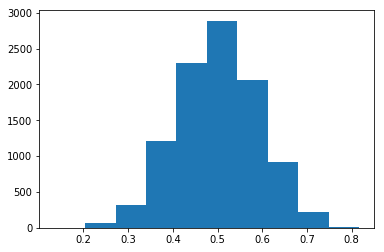

In [3]:
plt.hist(simulated_data)
plt.show()

## distribution of a slope

Here we do the same wirh an OLS regression.

TODO: add more text

In [4]:
N_simulations = 10000
sample_size = 100
slope = 0.5
constant = 1.0
noise = 0.1
simulated_x = tf.random.normal([N_simulations,sample_size])
simulated_y = constant + slope * simulated_x + noise*tf.random.normal([N_simulations,sample_size])





In [5]:
constants = []
slopes = []

for i in range(N_simulations):
  model = sm.OLS(simulated_y[i,:].numpy(), sm.add_constant(simulated_x[i,:].numpy()))
  results = model.fit().params
  constants.append(results[0])
  slopes.append(results[1])

We can derive the distributions of slopes:

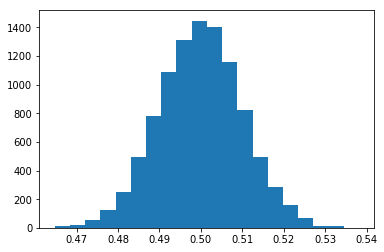

In [6]:
plt.hist(slopes,bins=20)
plt.show()

and the distribution of the constants:

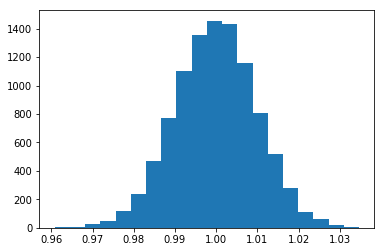

In [7]:
plt.hist(constants,bins=20)
plt.show()

We can plot the lines that are induced by these distributions of the constant and the slope

TODO: add more text

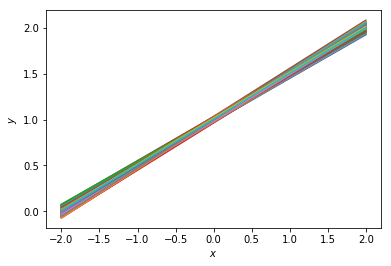

In [8]:
for i in range(1000):
  plt.plot([-2,2],[constants[i]+slopes[i]*(-2),constants[i]+slopes[i]*(2)])
  
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# Bootstrapping

Sometimes we do not know what the underlying model is that generated the data. We only have the sample that we observed.  How do we proceed in this case?


Suppose that we have two populations (e.g. men vs women; or in the test of a new drug: patients that got the treatment and patients that received the placebo). Denote these two samples by $A$ and $B$. 



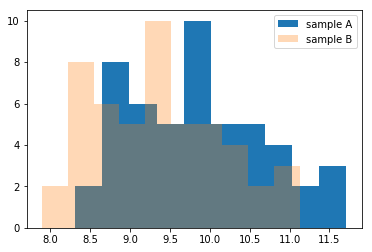

In [9]:
sample_size = 50
delta = 0.95
A = 10+tf.random.normal([sample_size])
B = A*delta
plt.hist(A,label='sample A')
plt.hist(B,alpha=0.3,label='sample B')
plt.legend()

We find that the average of $A$ is higher than the average of $B$, but is this a significant effect (forget for a second that you saw the code generating the data)?


In [10]:
observed_difference = np.mean(A)-np.mean(B)
print(observed_difference)

0.49256897


In your statistics class you have seen a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to figure out whether this difference is significant or not. But we are going to use simulations to establish this.

The null hypothesis that we want to test is: samples $A$ and $B$ are drawn from the same distribution.

If this is true, than we can simply combine the $A$ and $B$ observations, reshuffle them and calculate the difference. We do this 10,000 times and get a distribution of the difference



In [11]:
AB = tf.concat([A,B],axis=0).numpy()

In [12]:
differences = []

for i in range(10000):
  np.random.shuffle(AB)
  differences.append(np.mean(AB[:sample_size])-np.mean(AB[sample_size:]))
                             
                      

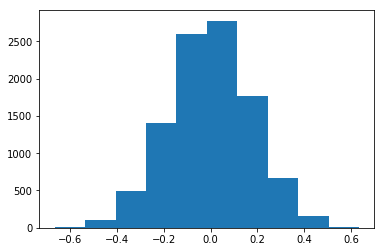

In [13]:
plt.hist(differences)
plt.show()

In [14]:
sum(differences>observed_difference)/len(differences)

0.0023

# Doing your own OLS

There exist many packages that can do OLS for you. But it is illustrative, to program your own OLS estimator, because then you can see what it does.

We start really simple and through the lecture we are going to make the estimator more sophisticated.

For OLS, we could just substitute the solution using matrix algebra: $\beta = (x^Tx)^{-1}x^Ty$. But we want to use the optimization problem itself so that we can add things to it later on.

First, we are going to generate our own data.

Then we define a loss function (mean squared error) and minimize the loss by choosing a constant (`w[0]`) and slope (`w[1]`).

In [15]:
sample_size = 500
slope = -3.0
constant = 1.0
x = tf.random.normal([sample_size])
y = slope*x+constant+3*tf.random.normal([sample_size])

def loss(w):
  return np.sum((w[0]+w[1]*x-y)**2)/len(y)

optimize.fmin(loss, [0,0])

Optimization terminated successfully.
         Current function value: 8.352144
         Iterations: 64
         Function evaluations: 129


array([ 0.98440987, -2.77901717])

# Causality

The data we generate is inspired by [Richard McElreath
's lecture 6](https://www.youtube.com/watch?v=l_7yIUqWBmE). 

As you know, multiple regression is about correlations, not about causality. When looking at the results of a multiple regression, there are a number of mistakes that you can make. Here we are going to look at four of these mistakes:

* the fork
* the pipe
* the collider
* the descendant

## The fork

To be added

## The pipe

To be added

## The collider

Many people have the intuition that adding a control variable to a regression (especially when it turns out to be signficant) is a good idea. However, this intuition is wrong if it is applied without thinking.

We use here the education example by Richard McElreath to illustrate this point. Consider the educational achievements of three generations in one family: the grandparent, the parent and the (grand)child. We are interested in the effect of the grandparent's education on the educational achievement of the grandchild. 

Let's denote the child's educational achievement by $Y$ (the variable we are interested in) and the grandparent's education $X$. We want to understand the effect of $x$ on $Y$. Clearly there is the following path: more educated grandparent leads to more educated parent which, in turn, leads to more educated grandchild. The thing we are interested in is whether there is a direct effect from the grandparent on the child, *controlling* for the parent's education.

We know that the parent's education has a positive effect on the child's achievement. A more educated parent will tend to stimulate their children more, can help with homework etc. In the data that we generate below, we assume that $Z = X + ...$ and $Y = Z + ...$. That is, we assume that the parent's education feeds one-to-one into the child's education. 

Is it the case that on top of this effect there is a separate grandparent effect? E.g. because the grandparent is babysitting and a more educated grandparent reads Hamlet with the 5 year old grandchild. That is fun and can boost the child's educational achievement.

Another important component of education is the neighborhood where the child grows up. We denote this variable $U$. In the code we assume that the parent and child grow up in the same neighborhood (have the same $U$ effect).  $U$ is drawn from a standard normal distribution and the effect on education is given through a multiplication by the factor `alpha`.

In addition to this, we assume that there is a random component as well which differs between parent and child.

The code below, generates this data and a dataframe `df` that stores this data.

Look carefully at the code: is there a direct effect from the grandparent to the grandchild's educational achievement?

We generate two dataframes: `df` is the one that is observed and used in the analysis by the researcher. 

We will use `df_2` to illustrate why one can get incorrect results from analyzing `df`. The problem is that the researcher does not have access to `df_2` but we can analyze `df_2` for "educational purposes" to illustrate why problems arise.

In [16]:
N_observations = 5000
alpha = 0.5
X = tf.random.normal([N_observations])
U = tf.random.normal([N_observations])
Z = X + alpha*U+0.4*tf.random.normal([N_observations])
Y = Z + alpha*U+0.4*tf.random.normal([N_observations])

df = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
df_2 = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z, 'U':U})
print(df.head())
print(df_2.head())

          X         Y         Z
0  0.575244  0.686931  0.348635
1  1.535746  0.477906  1.221836
2 -0.767106  0.185722 -0.462818
3 -1.548771 -0.160622 -1.307137
4 -0.091840 -1.842652 -1.131954
          X         Y         Z         U
0  0.575244  0.686931  0.348635  1.115407
1  1.535746  0.477906  1.221836 -0.452566
2 -0.767106  0.185722 -0.462818  0.751454
3 -1.548771 -0.160622 -1.307137  1.296408
4 -0.091840 -1.842652 -1.131954 -0.740007


To find the (direct) effect of the grandparent ($X$) and the grandchild's educational achievement ($Y$) conditional on the parent ($Z$), we use multiple regression where both $x$ and $Z$ are used as explanatory variables:

In [17]:
results = smf.ols('Y ~ X + Z', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 1.904e+04
Date:                Fri, 14 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:32:13   Log-Likelihood:                -3780.6
No. Observations:                5000   AIC:                             7567.
Df Residuals:                    4997   BIC:                             7587.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0157      0.007      2.150      0.0

The effect of the grandparent's educational achievement ($X$) on the child's achievement is negative and significant. Where does that come from? How is this even possible?

If we consider the direct effect of $X$ on $Y$ it is --as expected-- positive and significant:

In [18]:
results2 = smf.ols('Y ~ X', data=df).fit()
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     3800.
Date:                Fri, 14 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:32:14   Log-Likelihood:                -7752.2
No. Observations:                5000   AIC:                         1.551e+04
Df Residuals:                    4998   BIC:                         1.552e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0097      0.016      0.602      0.5

To see what is happening here in a graph, let's think about what it means to "control for parental education $Z$". 

To visualize what happens, we condition on $Z$ by focusing on a narrow band of $Z$ observations. In other words, we condition on $Z$ by focusing on a subsample where the $Z$ values are (almost) the same. We do this by creating a column `selected` in our dataframe.

In [19]:
df['selected'] = np.abs(df.Z)<0.05

In [20]:
df.head()

,X,Y,Z,selected
0,0.575244,0.686931,0.348635,False
1,1.535746,0.477906,1.221836,False
2,-0.767106,0.185722,-0.462818,False
3,-1.548771,-0.160622,-1.307137,False
4,-0.091840,-1.842652,-1.131954,False


Feel free to make this plot using `matplotlib`. For fun, we use `altair` here. 

The blue circles are all the data, the orange ones are the data with (almost) the same $Z$.

**Question** Give the intuition why there is a negative correlation between $X$ and $Y$ with the orange dots. [hint: what do you know about orange dots with low $X$ and about orange dots with high $X$?]

If you cannot answer this question yet, consider the following interactive graph.



In [21]:

chart = alt.Chart(df).mark_point().encode(
  x='X',
  y='Y',
  color='selected'
).interactive()

chart.save('Chart.html')

In [22]:
%%HTML

<iframe width="840" height="400" src="./Chart.html" frameborder="0"></iframe>

To better understand what is happening here, we are going to use `df_2`. In particular, in the combined figure below, we again provide a scatter plot of `X` vs `Y`. Now the color indicates the level of `Z` associated with the observation; darker colors indicate higher values of `Z`. The size of the point (circle) indicates the level of `U` (that the researcher cannot see in `df`). 

To condition on `Z` (as we do in a multiple regression), we can drag a rectangle in the bottom histogram. Move this histogram around and see what happens. In particular:
* how does `Z` vary in the figure? E.g. where are the high values of `Z`? What is the interpretation of this?
* for a selection of `Z` in the bottom histogram, what is the relation between `X` and `Y`?
* for this selection, how does `U` vary in the figure? What is the interpretation?


**Question** Give the intuition why there is a negative correlation between `X` and `Y` for a selection of `Z`; that is, conditional on `Z`.

**Exercise** What is the risk of saying: I have run a regression and controlled for all effects that I had variables for?

In [23]:
interval = alt.selection_interval(encodings=['y'])

fig = alt.Chart(df_2).mark_point().encode(
  x='X',
  y='Y',
  color=alt.condition(interval, 'Z', alt.value('lightgreen')),
  size = 'U'
).properties(
    selection=interval

)



hist = alt.Chart(df_2).mark_bar().encode(
    x='count()',
    y=alt.Y('Z',bin=True),
    color=alt.condition(interval, 'Z', alt.value('lightgrey'))
).properties(
    selection=interval

)

chart2 = fig & hist

chart2.save('Chart2.html')

In [24]:
%%HTML

<iframe width="840" height="800" src="./Chart2.html" frameborder="0"></iframe>

## The descendant


In the three cases above, it sometimes happens that you do not have data on $Z$, but you have data on a variable $A$ correlated with $Z$. This is called a descendant.

To be added

# Some background on tensors

We will have a technical interlude to explain what tensors are and what you can do with them. We describe some functions that can be applied to tensors. To motivate these functions, we will build our first neural network. The point here is not so much to explain how neural networks works but more to show you that the functions we consider are going to be useful later on when we will try to understand neural networks more deeply.

## Tensors

In most of the empirical analyses that you have done, an observation is a one dimensional vector. E.g. you have data on inflation, unemployment, gdp growth for country-year combinations. Then for the UK in 2000, our data  consists of the one dimensional vector `[inflation, unemployment, gdp growth]`. If you have 100 observations like this, you can represent them in a matrix. Each row is an observation and the columns will be `[coutry, year, inflation, unemployment, gdp growth]`. Hence we have a two dimensional dataset with 100 rows and 5 columns.

In big data, there are usually higher dimension observations. One of the "classic" datasets in machine learning is [the MNIST dataset.](https://en.wikipedia.org/wiki/MNIST_database) This dataset consists of handwritten numbers and their corresponding label (e.g. when the handwritten number is 5, the label for this image `5`). We will see an example shortly.

The point is that a handwritten number is a two dimensional observation. To illustrate this, consider the 5th image from the training dataset (python starts numbering at 0); we plot the handwritten image (which is 2 dimensional) and print its label.



In [25]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

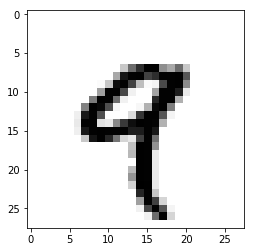

9


In [26]:
plt.imshow(train_images[4],cmap=plt.cm.binary)
plt.show()
print(train_labels[4])

Indeed, the handwritten number is 9, which equals its label.

What are the dimensions for this dataset. Let's use `shape` to find out:

In [27]:
train_images.shape

(60000, 28, 28)

In [28]:
train_images[0].shape

(28, 28)

## Tensors in numpy

Well known machine learning backends are Theano and Tensorflow. For reasons that we do not worry about here, these are not immediately straightforward to work with. But we can play around with dimensions in Numpy as well. Properties that we can use in Numpy, like broadcasting, can be used in Theano and Tensorflow as well.

As Numpy is "more direct" to work with, we will practice this with numpy.

First, we create the vector `x` with 100 random numbers. 

In [29]:
x = np.random.normal(0,1,size=100)

We can check what the shape is of this vector:

In [30]:
x.shape

(100,)

and the vector is one-dimensional from a tensor point of view:

In [31]:
x.ndim

1

**No not read this if you get easily confused:** If you would plot the vector `x` it would be a *vector* in a 100-dimensional space. Hence it is a 100 dimensional vector, but a 1 dimensional tensor.


Let us know consider a two dimensional (2D) tensor. This is what we usually call a matrix

In [32]:
x2 = x.reshape(25,4)

In [33]:
x2.ndim

2

In [34]:
x2.shape

(25, 4)

In matrix terminology we would say that `x2` has 25 rows and 4 columns.

A 3D tensor is then

In [35]:
x3 = x.reshape(4,5,5)

In [36]:
x3.ndim

3

In [37]:
x3.shape

(4, 5, 5)

One way to think about this is as four $5*5$ images.

The numpy representation of this is as follows:

In [38]:
x3

array([[[ 2.19369536e-01,  5.12505378e-01,  1.74975939e+00,
         -3.47936411e-01, -7.47733248e-01],
        [ 3.20643552e-01,  3.27164249e-01,  1.99096851e-01,
          2.18143064e+00,  1.14916521e-01],
        [-2.58629498e-03,  1.42539415e-01,  1.74945969e-02,
          2.52766801e-02,  6.93810235e-01],
        [ 9.98663536e-01,  1.82483586e-01,  1.81161326e+00,
         -1.66393456e+00, -8.33222764e-01],
        [-4.97944858e-01, -1.15270593e+00, -1.94713419e-01,
          1.16114920e+00,  9.46438604e-01]],

       [[-8.75028945e-01,  7.59647286e-01, -1.53679309e+00,
          5.29211358e-01,  4.51529637e-01],
        [-9.72065122e-01,  1.92045666e+00,  7.28224052e-01,
         -5.30702027e-01,  1.09534022e+00],
        [-1.58952103e+00,  5.20235137e-01,  1.32405555e+00,
         -7.44512151e-01, -9.90095298e-01],
        [-8.46913355e-01,  7.87507919e-01,  2.39144613e-01,
         -1.54033003e+00,  3.81375288e-01],
        [-6.70786644e-01,  2.56941347e-01, -2.44577495e-01,
  

we can also add a dimension to a vector without adding or re-arranging data. For this we use `np.newaxis`

In [39]:
x4 = x3[:,:,:,np.newaxis]

In [40]:
x4.ndim

4

In [41]:
x4.shape

(4, 5, 5, 1)

Now you may wonder why this is a useful thing to do.

## Broadcasting

Suppose you have estimated a fixed effect model. In your data there are i = 0,1,...,9 individuals and t = 0,1,2 periods. The vector `I` consists of 10 individual fixed effects and the vector `T` has 3 time fixed effects. Hence, our prediction for indiv. `i` in time period `t` (ignoring other explanatory variables) is $y_{it}=I_i+T_t$. 

How can we calculate the vector `y`?

We first give you the answer using broadcasting and then we step back to explain what broadcasting is.




In [42]:
I = np.arange(10)
T = np.arange(0,30,10)

In [43]:
I

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
T

array([ 0, 10, 20])

Because of the simplistic numbers that we have chosen, it is easy to see that e.g. $y_{31} = 13$ with $i=3$ and $t=1$. So we can check whether our trick works.

In [45]:
y = I[:,np.newaxis]+T[np.newaxis,:]

In [46]:
y

array([[ 0, 10, 20],
       [ 1, 11, 21],
       [ 2, 12, 22],
       [ 3, 13, 23],
       [ 4, 14, 24],
       [ 5, 15, 25],
       [ 6, 16, 26],
       [ 7, 17, 27],
       [ 8, 18, 28],
       [ 9, 19, 29]])

In [47]:
I[:,np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [48]:
T[np.newaxis,:]

array([[ 0, 10, 20]])

What is going on here?

## Slicing and reshape

## First neural network

In [49]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [50]:
model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 4s 65us/sample - loss: 2.4817 - accuracy: 0.8494
Epoch 2/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3888 - accuracy: 0.9093
Epoch 3/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2885 - accuracy: 0.9277
Epoch 4/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2497 - accuracy: 0.9371
Epoch 5/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2331 - accuracy: 0.9410


In [51]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)


10000/10000 [==============================] - 0s 24us/sample - loss: 0.2480 - accuracy: 0.9419

Test accuracy: 0.9419


In [52]:
predictions = model.predict(test_images)
predictions[0]

array([8.2998919e-17, 1.4780405e-14, 1.7457333e-04, 1.4094993e-05,
       8.5799106e-23, 2.3756936e-12, 1.8171436e-29, 9.9981135e-01,
       1.4554005e-14, 5.4778014e-13], dtype=float32)

In [53]:
np.argmax(predictions[0])


7

In [54]:
test_labels[0]


7

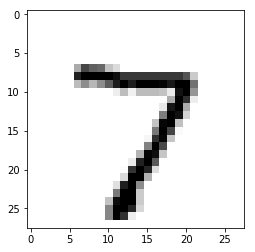

In [55]:
plt.imshow(test_images[0],cmap=plt.cm.binary)
plt.show()

## Functions

What is `relu` and `softmax`? What does `adam` mean?


In [0]:
np.maximum(z,0)

In [0]:
np.relu(10,0)

AttributeError: ignored

In [0]:
np.dot

# Overfitting and underfitting


Adding more explanatory variables to a regression cannot make the fit worse. This is easy to see: if it would become worse, you would set the coefficient on the added variables to 0. That would give the same fit as before. In real applications that may not be completely true as there is often randomness in the routines that are being used.

underfitting is ...

overfitting is ...


So how can we choose what the right model is?

A simple idea is cross validation. This idea is seen a lot in data science. Here we consider a simple example to illustrate cross validation.






## Regression in tensorflow

Below we will run regressions for a number of models. To understand what happens, let us first run a simple regression to see what the syntax looks like.

There are a number of python packages with which you can do a regression analysis. For example, [statsmodels](https://www.statsmodels.org/stable/index.html) has a nice syntax and by default returns things like t-values etc. If you just need to run a regression or two, than this is a great choice.

But if we want to program a series of regressions, tensorflow or [scikit-learn](https://scikit-learn.org/stable/index.html) are more useful as they are easier to program.

Here we use tensorflow.

First, we generate some simple data and add these to a dataframe.






In [56]:
N_observations = 50
train_size = 25
x = tf.random.normal([N_observations])
y = 3*x+5*tf.random.normal([N_observations])
df = pd.DataFrame({'y':y,'x':x})
df['constant'] = 1


In [57]:
features = ['constant','x']

y_train = df['y'][:train_size]
y_test =  df['y'][train_size:]

In [58]:
def make_input_fn(data_df, label_df, num_epochs=10, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [59]:
df_train = df[features][:train_size]
df_test = df[features][train_size:]
NUMERIC_COLUMNS = features
feature_columns = []
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn = make_input_fn(df_test, y_test)
  
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
linear_est.train(train_input_fn)

W0614 19:34:17.814179 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmp2hfdpnay
W0614 19:34:17.820864 140735602623360 deprecation.py:323] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0614 19:34:17.855100 140735602623360 deprecation.py:323] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0614 19:34:18.078471 140735602623360 deprecat

In [60]:
linear_est.evaluate(train_input_fn)


W0614 19:34:26.690412 140735602623360 deprecation.py:323] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


{'average_loss': 27.827478,
 'label/mean': 1.6509315,
 'loss': 27.82748,
 'prediction/mean': 1.3681078,
 'global_step': 10}

## Series of regressions


To illustrate overfitting, we construct a dataset, generating $y$ values from some $x$ vector

In [61]:
N_observations = 50
train_size = 25
x = tf.random.normal([N_observations])
y = 100*x+np.cos(x)-4*np.exp(x)+x**2+x**5-x**3+55*tf.random.normal([N_observations])
df = pd.DataFrame({'y':y,'x':x})
df['constant'] = 1
df['x2'] = df.x**2
df['x3'] = df.x**3
df['x4'] = df.x**4
df['x5'] = df.x**5
df['x6'] = df.x**6
df['x7'] = df.x**7
df['x8'] = df.x**8
df['x9'] = df.x**9
df['x10'] = df.x**10


In [62]:
features = ['constant','x','x2','x3','x4','x5','x6','x7','x8','x9','x10']

y_train = df['y'][:train_size]
y_test =  df['y'][train_size:]

In [63]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=False, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function


In [64]:
def make_input_fn(data_df, label_df, num_epochs=10, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_score = []
test_score = []
number_features = []

for i in range(2,len(features)+1):
  df_train = df[features[:i]][:train_size]
  df_test = df[features[:i]][train_size:]
  NUMERIC_COLUMNS = features[:i]
  feature_columns = []
  for feature_name in NUMERIC_COLUMNS:
      feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
      
  train_input_fn = make_input_fn(df_train, y_train)
  eval_input_fn = make_input_fn(df_test, y_test)
  
  linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
  linear_est.train(train_input_fn)
  
  print(i)
  number_features.append(i)
  train_score.append(linear_est.evaluate(train_input_fn)['average_loss'])
  test_score.append(linear_est.evaluate(eval_input_fn)['average_loss'])
  
   


W0614 19:34:35.843143 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmpbb7kltch


2


W0614 19:34:37.865765 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmpo94y4_wl


3


W0614 19:34:40.035088 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmp3pn6uzqd


4


W0614 19:34:42.542291 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmpr00f8yt9


5


W0614 19:34:45.353739 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmpsm_q3zjq


6


W0614 19:34:48.498611 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmp4ajdvzq1


7


W0614 19:34:51.884017 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmpvfl1_kyn


8


W0614 19:34:55.495949 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmp7r5i8ndl


9


W0614 19:34:59.405158 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmp52hf0yom


10


W0614 19:35:03.549828 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmpzdjypfin


11


In [65]:
outcome = pd.DataFrame({'x_i':number_features, 'train_score': train_score, 'test_score': test_score})  
outcome

,x_i,train_score,test_score
0,2,12518.250977,7285.670410
1,3,12408.869141,7390.244629
2,4,11899.289062,7176.062012
3,5,11483.595703,7467.850098
4,6,10112.750977,6900.551270
5,7,9743.199219,7501.470703
6,8,8984.423828,6107.690430
7,9,8974.168945,6033.361328
8,10,9282.704102,5964.391602
9,11,9844.468750,6660.434570


The following graph shows that adding more terms $x^a$ always helps to get a better fit on the training data. The loss measure falls as we add more terms.

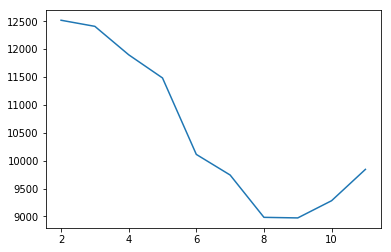

In [66]:
plt.plot(range(2,12),outcome.train_score)


But this is not the case with the test data. We fitted the model on the training data. Now we consider how well the model predicts "out-of-sample" on the test data. Adding 6 terms helps to predict on the test data. However, with more terms added to the model, the model starts to pick up features that are specific to our sample in the training data. These features are nor general to the underlying process. Hence, our loss increases on the test data.

By adding more than 6 terms, we start to overfit in this example.

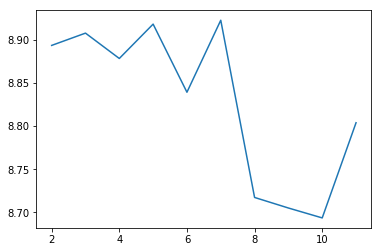

In [67]:
plt.plot(range(2,12),np.log(outcome.test_score))


# OLS using Tensorflow

Using more functionality from Tensorflow to program our OLS.

This allows us to see some building blocks that we will need below to program our neural network.

# Program your own Lasso

With OLS, adding variables is always "good" in terms of in-sample fit. But it can lead to overfitting. 

One way to avoid overfitting is to introduce a penalty for using more variables. This is the idea of Lasso.

Here you are going to program your own Lasso.




# Cross validation


k-fold cross-validation

# Neural network

To get a first sense of how a neural network works, we look at two simple python programs that implement these algorithms. For this, we use the website from the book [machine learning: an algorithmic perspective](http://homepages.ecs.vuw.ac.nz/~marslast/MLbook.html).

Below you find the code for the files [pcn_logic_eg.py](http://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch3/pcn_logic_eg.py) and [mlp.py](http://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch4/mlp.py); which we adapted for python 3 by adjusting the print statements (should be `print()` in python 3).

By looking at the underlying code we get an idea how neural networks work. Then we create a neural network using tensorflow 2.0. This part is based on a [tensorflow 2.0 tutorial](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/estimators/premade_estimators.ipynb).

The tensorflow syntax is very similar to [Keras](https://keras.io/). There is a [datacamp course](https://www.datacamp.com/courses/deep-learning-in-python) on deep learning with Keras.

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

First we install/import the libraries that we need.

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd
import numpy as np

In [4]:
from scipy import optimize
import matplotlib.pyplot as plt
import altair as alt

## Perceptron

Next we copy from Chapter 3 of Machine Learning: An Algorithmic Perspective, the "perceptron". The code is in the next cell. Try to understand the python.




The main part of the algorithm is in the function (method, actually, but do not worry about this) `pcntrain`; the line

`self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)`

determines how the weights in the network are updated. This optimization step is discussed in [this chapter of the datacamp course.](https://campus.datacamp.com/courses/deep-learning-in-python/optimizing-a-neural-network-with-backward-propagation?ex=1)



In [5]:
# Code from Chapter 3 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014



class pcn:
	""" A basic Perceptron (the same pcn.py except with the weights printed
	and it does not reorder the inputs)"""
	
	def __init__(self,inputs,targets):
		""" Constructor """
		# Set up network size
		if np.ndim(inputs)>1:
			self.nIn = np.shape(inputs)[1]
		else: 
			self.nIn = 1
	
		if np.ndim(targets)>1:
			self.nOut = np.shape(targets)[1]
		else:
			self.nOut = 1

		self.nData = np.shape(inputs)[0]
	
		# Initialise network
		self.weights = np.random.rand(self.nIn+1,self.nOut)*0.1-0.05

	def pcntrain(self,inputs,targets,eta,nIterations):
		""" Train the thing """	
		# Add the inputs that match the bias node
		inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)
	
		# Training
		change = range(self.nData)

		for n in range(nIterations):
			
			self.activations = self.pcnfwd(inputs);
			self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)
			print("Iteration: ", n)
			print(self.weights)
			
			activations = self.pcnfwd(inputs)
			print("Final outputs are:")
			print(activations)
		#return self.weights

	def pcnfwd(self,inputs):
		""" Run the network forward """

		# Compute activations
		activations =  np.dot(inputs,self.weights)

		# Threshold the activations
		return np.where(activations>0,1,0)

	def confmat(self,inputs,targets):
		"""Confusion matrix"""

		# Add the inputs that match the bias node
		inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)
		outputs = np.dot(inputs,self.weights)
	
		nClasses = np.shape(targets)[1]

		if nClasses==1:
			nClasses = 2
			outputs = np.where(outputs>0,1,0)
		else:
			# 1-of-N encoding
			outputs = np.argmax(outputs,1)
			targets = np.argmax(targets,1)

		cm = np.zeros((nClasses,nClasses))
		for i in range(nClasses):
			for j in range(nClasses):
				cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

		print(cm)
		print(np.trace(cm)/np.sum(cm))




Below you see 4 data points with a target value (0 or 1) for each data point. We need to predict the target value. We plot this with a red color for target 0 and blue for target 1.

Predicting the target here means finding a straight line such that all red points are on one side of the line and the blue points on the other side of the line. Since this example is very simple, you can draw the line yourself (I hope...). This simplicity helps us to understand what the algorithm does.

We define a tensor with 4 `inputs` and 4 `targets`. The first element of `inputs` (which has two coordinates) corresponds to the first element in `targets`.

To refer to the points in the figure, we use "standard" terminology $x$ and $y$.


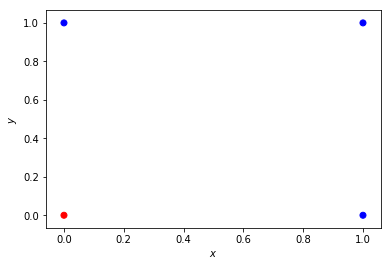

In [6]:
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
targets = np.array([[0],[1],[1],[1]])
colors = []
for i in range(len(targets)):
    colors.append(['red','blue'][targets[i][0]])
plt.scatter(inputs[:,0],inputs[:,1],color=colors)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Now we use the `pcn` class and instantiate it with the `inputs` and `targets` above. We call `p` and instance of the class `pcn`. In this course we will not dwell on the object oriented aspects of python, so do not worry if you do not fully understand this. However, as you will see below, when we use tensorflow, we have a similar structure: we create an instance of a tensorflow class.

The function definition is `pcntrain(self,inputs,targets,eta,nIterations)`. Do not worry about the `self` part. We call the function as `pcntrain(inputs,targets,0.25,6)`. Hence, the first two arguments of the function are our `inputs` and `targets` tensors. 

**Continue**

The result is that `p` is now associated with our tensors `inputs` and `targets`. Now we can use the function ("method") `pcntrain` to train the network. After each iteration, the algorithm prints some information. Looking at `pcntrain` above, we can see that the information that is printed is:

```
print("Iteration: ", n)
print(self.weights)
print("Final outputs are:")
print(activations)
```

So first we see the number of the iteration (and python starts counting at 0). Then we see three numbers that correspond to the weights. The weights determine the line in the figure above. In particular, if we write the weights tensor as $w = (w_0,w_1,w_2)$, then a line in the figure is given by $w_0 x + w_1 y =w_2$. Equivalently, we can write this as:

\begin{equation}
y = (w_2-w_0 x)/w_1
\end{equation}

Next, we see the final outputs (targets): this is the "prediction" of the algorithm for the vector `targets`. Recall that `targets` is of the form [0,1,1,1]. Hence, after the first iteration, we incorrectly label the first point as 1 while it should be 0. Hence, the algorithm continues and generates different (and ultimately better) predictions.


In [7]:
p = pcn(inputs,targets)
p.pcntrain(inputs,targets,0.25,6)

Iteration:  0
[[ 0.2943738 ]
 [ 0.45185078]
 [-0.47965965]]
Final outputs are:
[[1]
 [1]
 [1]
 [1]]
Iteration:  1
[[ 0.2943738 ]
 [ 0.45185078]
 [-0.22965965]]
Final outputs are:
[[1]
 [1]
 [1]
 [1]]
Iteration:  2
[[0.2943738 ]
 [0.45185078]
 [0.02034035]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  3
[[0.2943738 ]
 [0.45185078]
 [0.02034035]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  4
[[0.2943738 ]
 [0.45185078]
 [0.02034035]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  5
[[0.2943738 ]
 [0.45185078]
 [0.02034035]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]


The final weights $w$ are now equal to:

In [8]:
p.weights

array([[0.2943738 ],
       [0.45185078],
       [0.02034035]])

We can now plot the line $y=(w_2-w_0 x)/w_1$. Indeed, as you can see, the line sepates the red point (below the line) from the blue points (above the line). If we give the algorithm a point above the line, it will predict "blue", if we give it a point below the line it will predict "red". 

Because we only have 4 points here, this is arbitrary for points close to the line: we can shift the line, still separate the points, but get different predictions for points close to the line.

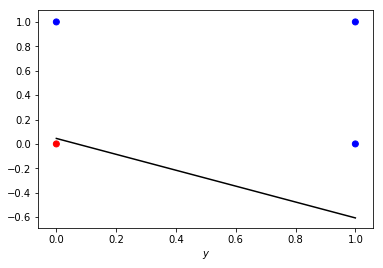

In [9]:
x0 = 0
x1 = 1
y0 = (p.weights[2]-p.weights[0]*x0)/p.weights[1]
y1 = (p.weights[2]-p.weights[0]*x1)/p.weights[1]
plt.scatter(inputs[:,0],inputs[:,1],color=colors)
plt.plot([x0,x1],[y0,y1],'k') #we only need to give two points to plot a line
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.show()

We can see from the graph and check with the function `pcnfwd` below what the predicted labels will be for the points (0.5,0.5) and (0.5,-0.5). The `-1` is needed for the "constant" $w_2$.

In [10]:
p.pcnfwd([[0.5,0.5,-1],[0.5,-0.5,-1]])

array([[1],
       [0]])

## Multi-layer perceptron

With more than one layer, we get into deep learning.

We use [this mlp code](http://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch4/mlp.py) from Chapter 4 of Machine Learning: An Algorithmic Perspective.

In [11]:

# Code from Chapter 4 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014

import numpy as np

class mlp:
    """ A Multi-Layer Perceptron"""
    
    def __init__(self,inputs,targets,nhidden,beta=1,momentum=0.9,outtype='logistic'):
        """ Constructor """
        # Set up network size
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nhidden = nhidden

        self.beta = beta
        self.momentum = momentum
        self.outtype = outtype
    
        # Initialise network
        self.weights1 = (np.random.rand(self.nin+1,self.nhidden)-0.5)*2/np.sqrt(self.nin)
        self.weights2 = (np.random.rand(self.nhidden+1,self.nout)-0.5)*2/np.sqrt(self.nhidden)

    def earlystopping(self,inputs,targets,valid,validtargets,eta,niterations=100):
    
        valid = np.concatenate((valid,-np.ones((np.shape(valid)[0],1))),axis=1)
        
        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000
        
        count = 0
        while (((old_val_error1 - new_val_error) > 0.001) or ((old_val_error2 - old_val_error1)>0.001)):
            count+=1
            print(count)
            self.mlptrain(inputs,targets,eta,niterations)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            validout = self.mlpfwd(valid)
            new_val_error = 0.5*np.sum((validtargets-validout)**2)
            
        print("Stopped", new_val_error,old_val_error1, old_val_error2)
        return new_val_error
    	
    def mlptrain(self,inputs,targets,eta,niterations):
        """ Train the thing """    
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((self.ndata,1))),axis=1)
        change = range(self.ndata)
    
        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))
            
        for n in range(niterations):
    
            self.outputs = self.mlpfwd(inputs)

            error = 0.5*np.sum((self.outputs-targets)**2)
            if (np.mod(n,100)==0):
                print("Iteration: ",n, " Error: ",error)

            # Different types of output neurons
            if self.outtype == 'linear':
            	deltao = (self.outputs-targets)/self.ndata
            elif self.outtype == 'logistic':
            	deltao = self.beta*(self.outputs-targets)*self.outputs*(1.0-self.outputs)
            elif self.outtype == 'softmax':
                deltao = (self.outputs-targets)*(self.outputs*(-self.outputs)+self.outputs)/self.ndata 
            else:
            	print("error")
            
            deltah = self.hidden*self.beta*(1.0-self.hidden)*(np.dot(deltao,np.transpose(self.weights2)))
                      
            updatew1 = eta*(np.dot(np.transpose(inputs),deltah[:,:-1])) + self.momentum*updatew1
            updatew2 = eta*(np.dot(np.transpose(self.hidden),deltao)) + self.momentum*updatew2
            self.weights1 -= updatew1
            self.weights2 -= updatew2
                
            # Randomise order of inputs (not necessary for matrix-based calculation)
            #np.random.shuffle(change)
            #inputs = inputs[change,:]
            #targets = targets[change,:]
            
    def mlpfwd(self,inputs):
        """ Run the network forward """

        self.hidden = np.dot(inputs,self.weights1);
        self.hidden = 1.0/(1.0+np.exp(-self.beta*self.hidden))
        self.hidden = np.concatenate((self.hidden,-np.ones((np.shape(inputs)[0],1))),axis=1)

        outputs = np.dot(self.hidden,self.weights2);

        # Different types of output neurons
        if self.outtype == 'linear':
        	return outputs
        elif self.outtype == 'logistic':
            return 1.0/(1.0+np.exp(-self.beta*outputs))
        elif self.outtype == 'softmax':
            normalisers = np.sum(np.exp(outputs),axis=1)*np.ones((1,np.shape(outputs)[0]))
            return np.transpose(np.transpose(np.exp(outputs))/normalisers)
        else:
            print("error")

    def confmat(self,inputs,targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)
        outputs = self.mlpfwd(inputs)
        
        nclasses = np.shape(targets)[1]

        if nclasses==1:
            nclasses = 2
            outputs = np.where(outputs>0.5,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nclasses,nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        print("Confusion matrix is:")
        print(cm)
        print("Percentage Correct: ",np.trace(cm)/np.sum(cm)*100)

This code is more elaborate than the perceptron above. It also introduces new concepts like the confusion matrix. We will go over these below. 

Before we use tensorflow with pandas dataframes, we first use more primitive datastructures in `numpy`. This serves two purposes: first, it is simple and helps to understand the underlying python code and algorithms; second, sometimes the data that you get is too messy to fit into a dataframe right away. Then it is useful to know some more primitive structures as well.

Below we read the famous [iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris). Admittedly, flowers are not directly linked to economics, but this is one of the classic datasets in classification. You cannot claim to have done "datascience" without having looked at the iris dataset.

We will first download it from the website, just to learn the relevant steps here. We will work with in numpy and then we turn it into a pandas dataframe. In fact, the data is so famous that it is included in the tensorflow library, but later you may want to analyze data that is not included in any library. Hence, we need to learn the download steps as well.

When you look at the downloaded data (in an editor), you will notice that it actually includes the names as strings. For us it is easier to work with numerical labels 0,1,2. Hence, we use the function `preprocessIris`. This function takes two arguments: the input file with the data that we downloaded and the output file where the target-labels are replaced by 0,1,2.

If you run this notebook for the first time, un-comment the line `preprocessIris('iris.data','iris_proc.data')` (that is, remove the hashtag "#" at the beginning of the line), where `iris.data` is the name of the file that you downloaded and `iris_proc.data` is the name of the file with labels 0,1,2. Once the file `iris_proc.data` is created, there is no need to run this python command again.

**continue here**

In [13]:
# Code from Chapter 4 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014

# The iris classification example

def preprocessIris(infile,outfile):

    stext1 = 'Iris-setosa'
    stext2 = 'Iris-versicolor'
    stext3 = 'Iris-virginica'
    rtext1 = '0'
    rtext2 = '1'
    rtext3 = '2'

    fid = open(infile,"r")
    oid = open(outfile,"w")

    for s in fid:
        if s.find(stext1)>-1:
            oid.write(s.replace(stext1, rtext1))
        elif s.find(stext2)>-1:
            oid.write(s.replace(stext2, rtext2))
        elif s.find(stext3)>-1:
            oid.write(s.replace(stext3, rtext3))
    fid.close()
    oid.close()

## Preprocessor to remove the test (only needed once)
# preprocessIris('iris.data','iris_proc.data')

iris = np.loadtxt('./data/iris_proc.data',delimiter=',')
iris[:,:4] = iris[:,:4]-iris[:,:4].mean(axis=0)
imax = np.concatenate((iris.max(axis=0)*np.ones((1,5)),np.abs(iris.min(axis=0)*np.ones((1,5)))),axis=0).max(axis=0)
iris[:,:4] = iris[:,:4]/imax[:4]
print(iris[0:5,:])

# Split into training, validation, and test sets
target = np.zeros((np.shape(iris)[0],3));
indices = np.where(iris[:,4]==0) 
target[indices,0] = 1
indices = np.where(iris[:,4]==1)
target[indices,1] = 1
indices = np.where(iris[:,4]==2)
target[indices,2] = 1

# Randomly order the data
order = np.arange(np.shape(iris)[0])
np.random.shuffle(order)
iris = iris[order,:]
target = target[order,:]

train = iris[::2,0:4]
traint = target[::2]
valid = iris[1::4,0:4]
validt = target[1::4]
test = iris[3::4,0:4]
testt = target[3::4]

#print train.max(axis=0), train.min(axis=0)

# Train the network
#import mlp
net = mlp(train,traint,5,outtype='logistic')
net.earlystopping(train,traint,valid,validt,0.1)
net.confmat(test,testt)


[[-0.36142626  0.33135215 -0.7508489  -0.76741803  0.        ]
 [-0.45867099 -0.04011887 -0.7508489  -0.76741803  0.        ]
 [-0.55591572  0.10846954 -0.78268251 -0.76741803  0.        ]
 [-0.60453809  0.03417533 -0.71901528 -0.76741803  0.        ]
 [-0.41004862  0.40564636 -0.7508489  -0.76741803  0.        ]]
1
Iteration:  0  Error:  30.38938998796759
2
Iteration:  0  Error:  0.9737398172734599
3
Iteration:  0  Error:  0.9332450435001935
4
Iteration:  0  Error:  0.9077011826593268
5
Iteration:  0  Error:  0.8833313812686364
6
Iteration:  0  Error:  0.8549547005715146
7
Iteration:  0  Error:  0.8181167690900505
8
Iteration:  0  Error:  0.7654267367970793
Stopped 1.014595799090922 1.0013482655915835 1.0001142973492751
Confusion matrix is:
[[13.  0.  0.]
 [ 0. 14.  0.]
 [ 0.  0. 10.]]
Percentage Correct:  100.0


In [14]:
preprocessIris('./data/iris.data','./data/iris_proc2.data')

In [15]:
iris

array([[-1.18314425e-01, -2.63001486e-01,  1.40492360e-01,
         7.78688525e-02,  1.00000000e+00],
       [ 3.67909238e-01, -1.14413076e-01,  2.67826825e-01,
         7.78688525e-02,  1.00000000e+00],
       [ 3.19286872e-01,  1.08469539e-01,  4.26994907e-01,
         6.15778689e-01,  2.00000000e+00],
       [-1.18314425e-01, -4.01188707e-02,  1.08658744e-01,
         7.78688525e-02,  1.00000000e+00],
       [-3.61426256e-01,  5.54234770e-01, -7.19015280e-01,
        -6.90573770e-01,  0.00000000e+00],
       [ 4.16531605e-01,  3.41753343e-02,  5.86162988e-01,
         9.23155738e-01,  2.00000000e+00],
       [ 2.70664506e-01,  3.41753343e-02,  5.54329372e-01,
         4.62090164e-01,  2.00000000e+00],
       [ 4.16531605e-01,  3.41753343e-02,  2.04159593e-01,
         1.54713115e-01,  1.00000000e+00],
       [ 1.24797407e-01, -4.01188707e-02,  3.63327674e-01,
         4.62090164e-01,  2.00000000e+00],
       [ 5.13776337e-01,  1.08469539e-01,  6.17996604e-01,
         8.46311475e-01

# Premade Estimators

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/tutorials/estimators/premade_estimators"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/estimators/premade_estimators.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/tree/master/site/en/r2/tutorials/estimators/premade_estimators.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


This tutorial shows you
how to solve the Iris classification problem in TensorFlow using Estimators. An Estimator is TensorFlow's high-level representation of a complete model, and it has been designed for easy scaling and asynchronous training. For more details see
[Estimators](https://www.tensorflow.org/guide/estimators).

Note that in TensorFlow 2.0, the [Keras API](https://www.tensorflow.org/guide/keras) can accomplish many of these same tasks, and is believed to be an easier API to learn. If you are starting fresh, we would recommend you start with Keras. For more information about the available high level APIs in TensorFlow 2.0, see [Standardizing on Keras](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a).



## First things first

In order to get started, you will first import TensorFlow and a number of libraries you will need.

## The data set

The sample program in this document builds and tests a model that
classifies Iris flowers into three different species based on the size of their
[sepals](https://en.wikipedia.org/wiki/Sepal) and
[petals](https://en.wikipedia.org/wiki/Petal).


You will train a model using the Iris data set. The Iris data set contains four features and one
[label](https://developers.google.com/machine-learning/glossary/#label).
The four features identify the following botanical characteristics of
individual Iris flowers:

* sepal length
* sepal width
* petal length
* petal width

Based on this information, you can define a few helpful constants for parsing the data:


In [16]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

Next, download and parse the Iris data set using Keras and Pandas. Note that you keep distinct datasets for training and testing.

In [17]:
train = pd.DataFrame({'SepalLength':iris[::2,0],'SepalWidth':iris[::2,1],'PetalLength':iris[::2,2],'PetalWidth':iris[::2,3],'Species':iris[::2,4]})
valid = pd.DataFrame({'SepalLength':iris[1::4,0],'SepalWidth':iris[1::4,1],'PetalLength':iris[1::4,2],'PetalWidth':iris[1::4,3],'Species':iris[1::4,4]})
test = pd.DataFrame({'SepalLength':iris[3::4,0],'SepalWidth':iris[3::4,1],'PetalLength':iris[3::4,2],'PetalWidth':iris[3::4,3],'Species':iris[3::4,4]})

In [18]:
train['Species']=train.Species.astype(int)
valid['Species']=valid.Species.astype(int)
test['Species']=test.Species.astype(int)

In [19]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,-0.118314,-0.263001,0.140492,0.077869,1
1,0.319287,0.108470,0.426995,0.615779,2
2,-0.361426,0.554235,-0.719015,-0.690574,0
3,0.270665,0.034175,0.554329,0.462090,2
4,0.124797,-0.040119,0.363328,0.462090,2


In [20]:
train_y = train.pop('Species')
valid_y = valid.pop('Species')
test_y = test.pop('Species')

# The label column has now been removed from the features.
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,-0.118314,-0.263001,0.140492,0.077869
1,0.319287,0.108470,0.426995,0.615779
2,-0.361426,0.554235,-0.719015,-0.690574
3,0.270665,0.034175,0.554329,0.462090
4,0.124797,-0.040119,0.363328,0.462090


You can inspect your data to see that you have four float feature columns and one int32 label.

## Overview of programming with Estimators

Now that you have the data set up, you can define a model using a TensorFlow Estimator. An Estimator is any class derived from `tf.estimator.Estimator`. TensorFlow
provides a collection of
`tf.estimator`
(for example, `LinearRegressor`) to implement common ML algorithms. Beyond
those, you may write your own
[custom Estimators](https://www.tensorflow.org/guide/custom_estimators).
We recommend using pre-made Estimators when just getting started.

To write a TensorFlow program based on pre-made Estimators, you must perform the
following tasks:

* Create one or more input functions.
* Define the model's feature columns.
* Instantiate an Estimator, specifying the feature columns and various
  hyperparameters.
* Call one or more methods on the Estimator object, passing the appropriate
  input function as the source of the data.

Let's see how those tasks are implemented for Iris classification.

## Create input functions

You must create input functions to supply data for training,
evaluating, and prediction.

An **input function** is a function that returns a `tf.data.Dataset` object
which outputs the following two-element tuple:

* [`features`](https://developers.google.com/machine-learning/glossary/#feature) - A Python dictionary in which:
    * Each key is the name of a feature.
    * Each value is an array containing all of that feature's values.
* `label` - An array containing the values of the
  [label](https://developers.google.com/machine-learning/glossary/#label) for
  every example.

Just to demonstrate the format of the input function, here's a simple
implementation:

In [21]:
def input_evaluation_set():
    features = {'SepalLength': np.array([6.4, 5.0]),
                'SepalWidth':  np.array([2.8, 2.3]),
                'PetalLength': np.array([5.6, 3.3]),
                'PetalWidth':  np.array([2.2, 1.0])}
    labels = np.array([2, 1])
    return features, labels

In [22]:
input_evaluation_set()

({'SepalLength': array([6.4, 5. ]),
  'SepalWidth': array([2.8, 2.3]),
  'PetalLength': array([5.6, 3.3]),
  'PetalWidth': array([2.2, 1. ])},
 array([2, 1]))

Your input function may generate the `features` dictionary and `label` list any
way you like. However, we recommend using TensorFlow's [Dataset API](https://www.tensorflow.org/guide/datasets), which can
parse all sorts of data.

The Dataset API can handle a lot of common cases for you. For example,
using the Dataset API, you can easily read in records from a large collection
of files in parallel and join them into a single stream.

To keep things simple in this example you are going to load the data with
[pandas](https://pandas.pydata.org/), and build an input pipeline from this
in-memory data:


In [23]:
def input_fn(features, labels, training=True, batch_size=256):
    """An input function for training or evaluating"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


## Define the feature columns

A [**feature column**](https://developers.google.com/machine-learning/glossary/#feature_columns)
is an object describing how the model should use raw input data from the
features dictionary. When you build an Estimator model, you pass it a list of
feature columns that describes each of the features you want the model to use.
The `tf.feature_column` module provides many options for representing data
to the model.

For Iris, the 4 raw features are numeric values, so we'll build a list of
feature columns to tell the Estimator model to represent each of the four
features as 32-bit floating-point values. Therefore, the code to create the
feature column is:

In [24]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

Feature columns can be far more sophisticated than those we're showing here.  You can read more about Feature Columns in [this guide](https://www.tensorflow.org/guide/feature_columns).

Now that you have the description of how you want the model to represent the raw
features, you can build the estimator.

## Instantiate an estimator

The Iris problem is a classic classification problem. Fortunately, TensorFlow
provides several pre-made classifier Estimators, including:

* `tf.estimator.DNNClassifier` for deep models that perform multi-class
  classification.
* `tf.estimator.DNNLinearCombinedClassifier` for wide & deep models.
* `tf.estimator.LinearClassifier` for classifiers based on linear models.

For the Iris problem, `tf.estimator.DNNClassifier` seems like the best choice.
Here's how you instantiated this Estimator:

In [25]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

W0614 20:27:59.070362 140735602623360 estimator.py:1799] Using temporary folder as model directory: /var/folders/b6/1x1jg8w113vfq8m_qkqym1sh0000gn/T/tmp8z1lsby5


## Train, Evaluate, and Predict

Now that you have an Estimator object, you can call methods to do the following:

* Train the model.
* Evaluate the trained model.
* Use the trained model to make predictions.

### Train the model

Train the model by calling the Estimator's `train` method as follows:

In [26]:
# Train the Model.
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)

W0614 20:28:04.495733 140735602623360 deprecation.py:323] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0614 20:28:04.602373 140735602623360 deprecation.py:506] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0614 20:28:04.608277 140735602623360 deprecation.py:323] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-pac

Note that you wrap up your `input_fn` call in a
[`lambda`](https://docs.python.org/3/tutorial/controlflow.html)
to capture the arguments while providing an input function that takes no
arguments, as expected by the Estimator. The `steps` argument tells the method
to stop training after a number of training steps.


### Evaluate the trained model

Now that the model has been trained, you can get some statistics on its
performance. The following code block evaluates the accuracy of the trained
model on the test data:


In [27]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

W0614 20:28:21.786128 140735602623360 deprecation.py:323] From /Users/boone/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.



Test set accuracy: 0.973



on the validation set:

In [28]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(valid, valid_y, training=False))

print('\nValidation set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Validation set accuracy: 0.947



Unlike the call to the `train` method, you did not pass the `steps`
argument to evaluate. The `input_fn` for eval only yields a single
[epoch](https://developers.google.com/machine-learning/glossary/#epoch) of data.


The `eval_result` dictionary also contains the `average_loss` (mean loss per sample), the `loss` (mean loss per mini-batch) and the value of the estimator's `global_step` (the number of training iterations it underwent).


### Making predictions (inferring) from the trained model

You now have a trained model that produces good evaluation results.
You can now use the trained model to predict the species of an Iris flower
based on some unlabeled measurements. As with training and evaluation, you make
predictions using a single function call:

In [29]:
# Generate predictions from the model
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

def input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predictions = classifier.predict(
    input_fn=lambda: input_fn(valid))

The `predict` method returns a Python iterable, yielding a dictionary of
prediction results for each example. The following code prints a few
predictions and their probabilities:

In [30]:
for pred_dict, expec in zip(valid, expected):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(
        SPECIES[class_id], 100 * probability, expec))

TypeError: string indices must be integers

# Treatment effects

Machine learning is about predicting outcomes. When the prediction is accurate (out-of-sample) we are happy, almost no matter what the model looks like.

This is different when we are interested in policy advice. 

# IV

What are instrumental variables again?

We use the IV example in [Richard McElreath's lecture 18
](https://www.youtube.com/watch?v=e5cgiAGBKzI) (starting around 28:00).

An individual's education (`e`) affects her wage (`w`). We want to know how strong this effect is.

`q` denotes fraction of the year that has elapsed when you were born.

**TODO** add text






In [31]:
N_observations=200
alpha_w = 1.
beta_ew = 0.
alpha_e = 1.
beta_qe = 2.
q = tf.random.uniform([N_observations])
u = tf.random.normal([N_observations])
e = alpha_e + beta_qe*q + u + tf.random.normal([N_observations])
w = alpha_w + beta_ew*e + u + tf.random.normal([N_observations])
df = pd.DataFrame({'q':q,'e':e,'w':w})

In [32]:
results = smf.ols('w ~ e', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     63.43
Date:                Fri, 14 Jun 2019   Prob (F-statistic):           1.28e-13
Time:                        20:30:15   Log-Likelihood:                -321.08
No. Observations:                 200   AIC:                             646.2
Df Residuals:                     198   BIC:                             652.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.152e-05      0.152      0.000      1.0

In [33]:

mod = IV2SLS.from_formula('w ~ 1 + [e ~ q]', df)

iv_res = mod.fit()
iv_res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      w   R-squared:                     -0.0333
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0385
No. Observations:                 200   F-statistic:                    0.0380
Date:                Fri, Jun 14 2019   P-value (F-stat)                0.8453
Time:                        20:30:16   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0620     0.3473     3.0581     0.0022      0.3814      1.7426
e             -0.0323     0.1655    -0.1951     0.8453     -0.3568      0.2922
==============================================================================

Endogenous: e
Instruments: q
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x1c30dd1da0

In [34]:
iv_res.first_stage

,e
R-squared,0.1886
Partial R-squared,0.1886
Shea's R-squared,0.1886
Partial F-statistic,46.335
P-value (Partial F-stat),9.965e-12
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,0.9643
,(5.7549)
q,2.0857
